\setcounter{secnumdepth}{0}


## Tool Usage Rationale

- Excel was used for initial exploratory analysis, simple correlations,
  and time-series visualization.
- Python was used for data engineering, monthly alignment, regime-based
  analysis, volatility modeling, and SQL-style aggregation.


 Project Introduction


# Impact of US Fed Funds Rate on S&P 500 and NIFTY Returns

**Objective:**  
This project uses Python for analytical modeling and Excel for initial
data preparation.Analyze how changes in the US Federal Reserve interest 
rates affect the monthly returns of S&P 500 and NIFTY indices from 2000 to 2025.

**Datasets Used:**  
1. US Fed Funds Rate (monthly)  
2. S&P 500 monthly data  
3. NIFTY monthly data

**Steps Overview:**  
1. Load and prepare Dataset
2. Merge datasets by month 
3. Calculate monthly returns  
4. Visualize Fed Rate vs Market Returns  
5. Analyze insights


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


## Data Loading and Preparation


In [2]:
# Reading Excel File

fed = pd.read_excel("DATA/CLEANED/FEDFUNDS.xlsx")     # Fed Funds Rate dataset
spx = pd.read_excel("DATA/CLEANED/^spx_m.xlsx")       # S&P 500 dataset
nifty = pd.read_excel("DATA/CLEANED/Nifty 50 Historical Data.xlsx")  # NIFTY dataset





In [3]:
# Renaming Columns

spx.rename(columns={'DATE-TIME': 'Date'}, inplace=True)
nifty.rename(columns={'DATE-TIME': 'Date'}, inplace=True)
nifty.rename(columns={'Monthly Return': 'NIFTY_Monthly_Return'}, inplace=True)






In [4]:
# Convert Date Columns To Datetime Format

spx['Date'] = pd.to_datetime(spx['Date'])
nifty['Date'] = pd.to_datetime(nifty['Date'])


In [5]:
# Sorting Data

fed = fed.sort_values('Date')
spx = spx.sort_values('Date')
nifty = nifty.sort_values('Date')


## Monthly Alignment and Dataset Merging
Different datasets report dates differently (month start vs month end), 
so monthly periods are used to ensure correct alignment.



In [6]:
# Rename Date Column To YearMonth 

fed['YearMonth'] = fed['Date'].dt.to_period('M')
spx['YearMonth'] = spx['Date'].dt.to_period('M')
nifty['YearMonth'] = nifty['Date'].dt.to_period('M')


In [7]:
# Merge datasets by YearMonth

master = pd.merge(
    fed[['YearMonth', 'Fed_Funds_Rate']],
    spx[['YearMonth', 'SP500_Monthly_Return']],
    on='YearMonth',
    how='inner'
)

master = pd.merge(
    master,
    nifty[['YearMonth', 'NIFTY_Monthly_Return']],
    on='YearMonth',
    how='inner'
)


## Correlation Analysis
The following correlation analysis is included to validate Excel-based findings
and motivate deeper regime and volatility analysis.





In [8]:
corr = master[['Fed_Funds_Rate',
               'SP500_Monthly_Return',
               'NIFTY_Monthly_Return']].corr()

corr


,Fed_Funds_Rate,SP500_Monthly_Return,NIFTY_Monthly_Return
Fed_Funds_Rate,1.000000,-0.038445,-0.027594
SP500_Monthly_Return,-0.038445,1.000000,0.535298
NIFTY_Monthly_Return,-0.027594,0.535298,1.000000


In [9]:
 # Convert Period to Timestamp for plotting

master['YearMonth_dt'] = master['YearMonth'].dt.to_timestamp()

## Market Behavior by Fed Rate Regimes


In [10]:

def rate_regime(rate):
    if rate < 2:
        return 'Low Rate (<2%)'
    elif rate <= 4:
        return 'Medium Rate (2–4%)'
    else:
        return 'High Rate (>4%)'

master['Rate_Regime'] = master['Fed_Funds_Rate'].apply(rate_regime)




In [11]:
regime_summary = master.groupby('Rate_Regime').agg(
    SP500_Avg_Return=('SP500_Monthly_Return', 'mean'),
    SP500_Volatility=('SP500_Monthly_Return', 'std'),
    NIFTY_Avg_Return=('NIFTY_Monthly_Return', 'mean'),
    NIFTY_Volatility=('NIFTY_Monthly_Return', 'std')
)

regime_summary


,SP500_Avg_Return,SP500_Volatility,NIFTY_Avg_Return,NIFTY_Volatility
Rate_Regime,,,,
High Rate (>4%),0.008282,0.037892,0.013158,0.056557
Low Rate (<2%),0.007237,0.045146,0.011794,0.063225
Medium Rate (2–4%),-0.002890,0.046531,0.004251,0.067710


## Regime Summary

Key observations:

- Market returns differ significantly across Fed rate regimes.
- Low-rate environments generally support higher average returns.
- High-rate regimes show increased volatility, reflecting uncertainty.
- Weak overall correlation exists because markets react differently under different regimes.

This explains why simple correlation analysis fails to capture the true Fed–market relationship.



## Regime Visualization


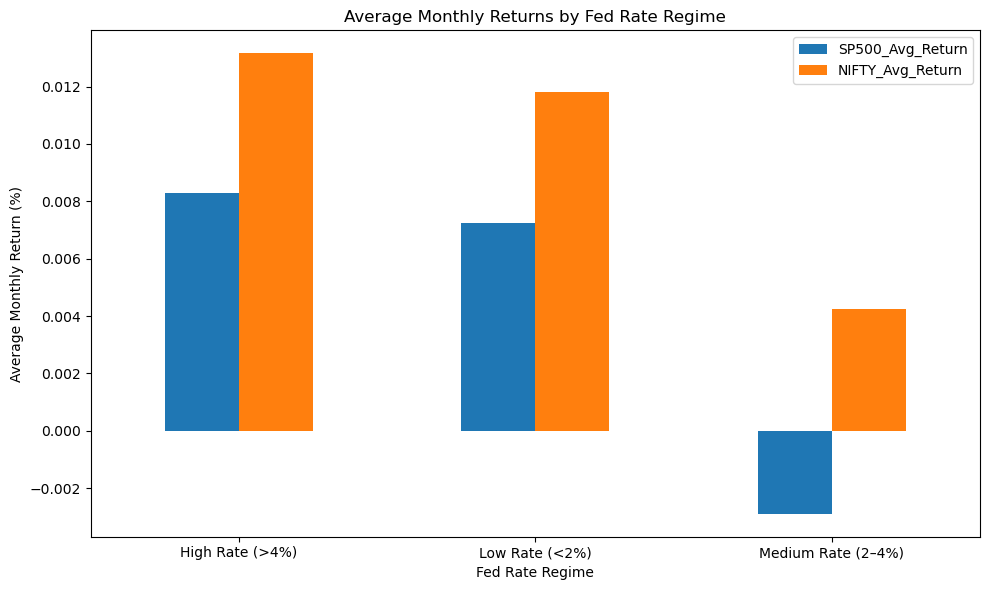

In [12]:
regime_summary[['SP500_Avg_Return', 'NIFTY_Avg_Return']].plot(
    kind='bar',
    figsize=(10,6)
)

plt.title('Average Monthly Returns by Fed Rate Regime')
plt.ylabel('Average Monthly Return (%)')
plt.xlabel('Fed Rate Regime')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


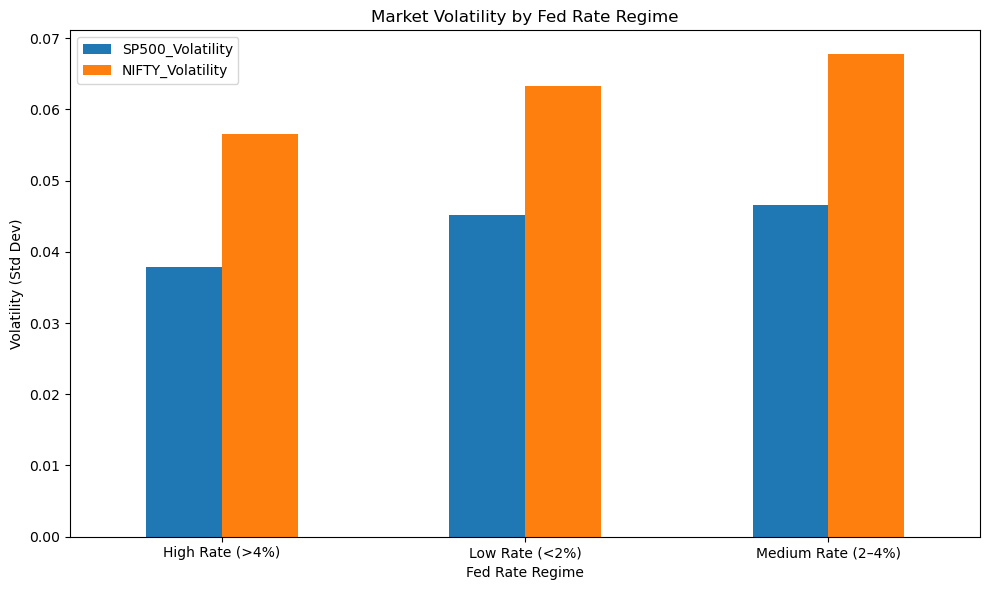

In [13]:
regime_summary[['SP500_Volatility', 'NIFTY_Volatility']].plot(
    kind='bar',
    figsize=(10,6)
)

plt.title('Market Volatility by Fed Rate Regime')
plt.ylabel('Volatility (Std Dev)')
plt.xlabel('Fed Rate Regime')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## MONTHLY RETURNS VS ROLLING VOLATILITY


In [14]:
# Calculate 12-month rolling volatility

master['SP500_Rolling_Volatility_12M'] = (
    master['SP500_Monthly_Return']
    .rolling(window=12)
    .std()
)

master['NIFTY_Rolling_Volatility_12M'] = (
    master['NIFTY_Monthly_Return']
    .rolling(window=12)
    .std()
)




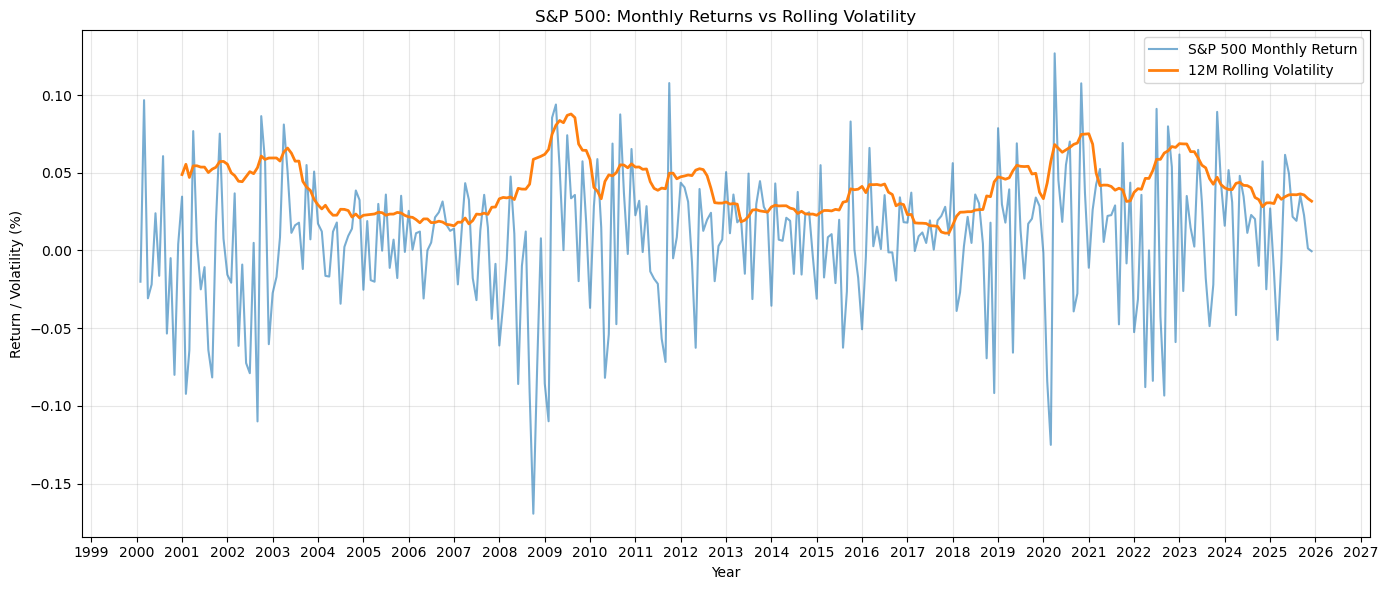

In [15]:


plt.figure(figsize=(14,6))

# Returns
plt.plot(master['YearMonth_dt'],
         master['SP500_Monthly_Return'],
         label='S&P 500 Monthly Return',
         alpha=0.6)

# Volatility
plt.plot(master['YearMonth_dt'],
         master['SP500_Rolling_Volatility_12M'],
         label='12M Rolling Volatility',
         linewidth=2)

plt.title('S&P 500: Monthly Returns vs Rolling Volatility')
plt.xlabel('Year')
plt.ylabel('Return / Volatility (%)')
plt.legend()
plt.grid(alpha=0.3)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()


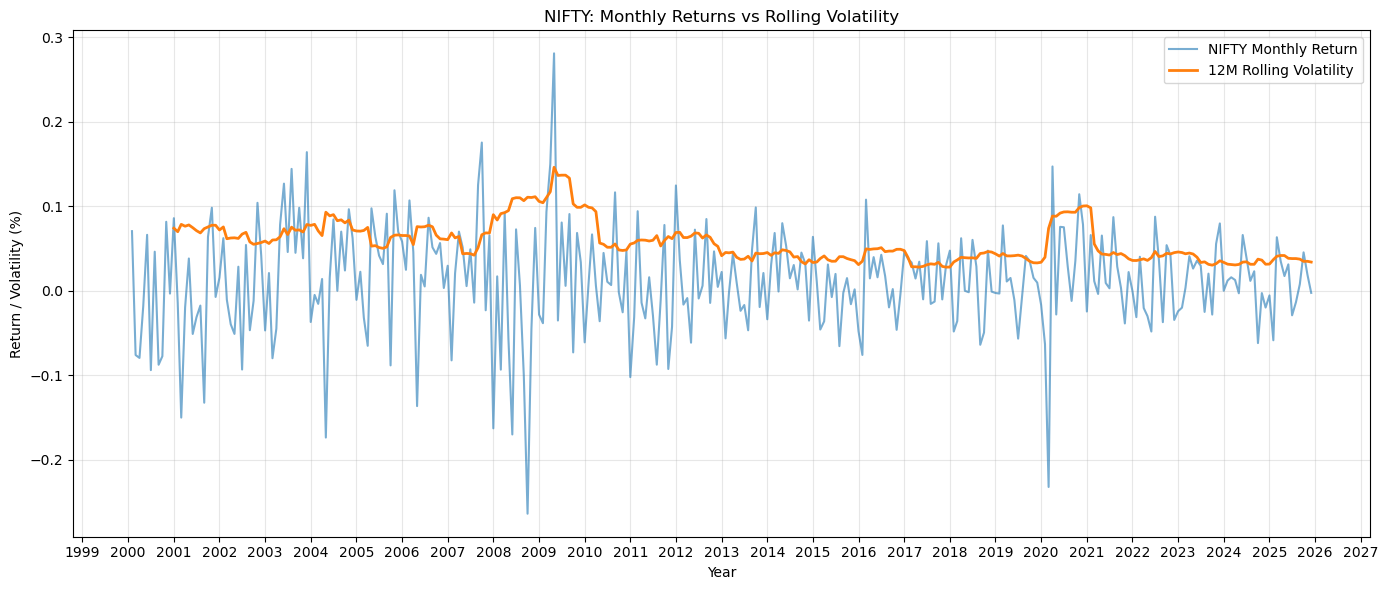

In [16]:
plt.figure(figsize=(14,6))

plt.plot(master['YearMonth_dt'],
         master['NIFTY_Monthly_Return'],
         label='NIFTY Monthly Return',
         alpha=0.6)

plt.plot(master['YearMonth_dt'],
         master['NIFTY_Rolling_Volatility_12M'],
         label='12M Rolling Volatility',
         linewidth=2)

plt.title('NIFTY: Monthly Returns vs Rolling Volatility')
plt.xlabel('Year')
plt.ylabel('Return / Volatility (%)')
plt.legend()
plt.grid(alpha=0.3)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()


## SQL-style Analysis (SQLite Demonstration)

This section demonstrates SQL-based aggregation logic using SQLite
to summarize market behavior across Fed rate regimes.


In [17]:
import sqlite3

master_sql = master.copy()
master_sql['YearMonth'] = master_sql['YearMonth'].astype(str)

conn = sqlite3.connect(':memory:')
master_sql.to_sql('market_data', conn, index=False, if_exists='replace')



312

The SQL results below validate the regime-based analysis performed using pandas.


In [18]:
query = """
SELECT
    Rate_Regime,
    AVG(SP500_Monthly_Return) AS avg_sp500_return,
    AVG(NIFTY_Monthly_Return) AS avg_nifty_return,
    AVG(SP500_Rolling_Volatility_12M) AS avg_sp500_volatility
FROM market_data
GROUP BY Rate_Regime
ORDER BY Rate_Regime;
"""

from IPython.display import display

sql_regime_summary = pd.read_sql(query, conn)

display(sql_regime_summary)



,Rate_Regime,avg_sp500_return,avg_nifty_return,avg_sp500_volatility
0,High Rate (>4%),0.008282,0.013158,0.035587
1,Low Rate (<2%),0.007237,0.011794,0.041781
2,Medium Rate (2–4%),-0.002890,0.004251,0.040494


In [19]:
conn.close()

## Volatility as a Driver of Market Behavior


- Market volatility spikes during crisis periods such as 2008 and COVID-19.
- During high volatility phases, returns become unstable and unpredictable.
- This explains why markets show weak correlation with Fed rate levels alone.
- Investors respond more strongly to uncertainty and risk than to interest rate levels.
- Thus, volatility plays a more dominant role than rate levels in driving short-term market behavior.

The following section summarizes the overall findings of the analysis.



## Dashboard Dataset Preparation

This section prepares a business-ready dataset for dashboard visualization.
All calculations are performed in Python; the exported file is used only for visualization.


In [20]:
# Select final columns required for dashboard
dashboard_df = master[[
    'YearMonth_dt',
    'Rate_Regime',
    'Fed_Funds_Rate',
    'SP500_Monthly_Return',
    'NIFTY_Monthly_Return',
    'SP500_Rolling_Volatility_12M',
    'NIFTY_Rolling_Volatility_12M'
]]

# Export dashboard dataset
dashboard_df.to_excel('dashboard_data.xlsx', index=False)


## Key Takeaways

• Market returns show weak linear correlation with Fed rate levels  
• Return behavior differs significantly across rate regimes  
• Volatility spikes align more with macroeconomic uncertainty than rate changes  
• Regime-based analysis explains why simple correlation fails
